In [1]:
import re
import io
import json
import tempfile

from copy import copy
from collections import Counter
from itertools import groupby, product, combinations
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt

from Bio import SeqIO, AlignIO, codonalign
from Bio.Align.Applications import MuscleCommandline
from Bio.Seq import Seq, MutableSeq

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


## Introduction

"Big data era", getting data is a challenge.
NCBI datasets making it easier to get data for addressing a question.
Here's a specific example of a problem that can be addressed with big data:

Bio problem:
- **Our question**: can we detect natural selection by comparing ortholog sequences between species?
- Review: the redundant genetic code, synonymous and non-synonymous substitutions (Not frameshift indels)
- The molecular clock: synonymous mutations accumulate at a constant rate [FIGURE]
- Purifying selection: most non-synonymous mutations are harmful and eliminated by natural selection [FIGURE]
- Positive selection: some non-synonymous mutations may improve fitness. These will fix at a faster-than-neutral rate [FIGURE]
- **Idea**: we can compare the rates of syn/non-syn substitutions to look for signals of purifying or positive selection

We will compute the **dN/dS ratio**, that is the ratio of non-synonymous to synonymous substitutions.
- Low dN/dS indicates strong purifying selection (meaning the gene is important and well-adapted).
- Intermediate -> relaxed purifying selection.
- High -> strong positive selection, rapid adaptation
[DIAGRAM]

We will be comparing Drosophila species [PHYLOGENY] with different levels of divergence across a large number of ortholog families to categorize the orthologs by dN/dS.

## Importing the sequences

In [2]:
datadir = "/data/orthologs_with_cds"

In [3]:
!tree $datadir

/data/orthologs_with_cds
├── 10178777.zip
├── 10178781.zip
├── 10178782.zip
├── 10178784.zip
├── 10178785.zip
├── 10178787.zip
├── 10178792.zip
├── 10178793.zip
├── 10178795.zip
├── 10178796.zip
├── 10178797.zip
├── 10178805.zip
├── 10178806.zip
├── 10178809.zip
├── 10178812.zip
├── 10178814.zip
├── 10178816.zip
├── 10178817.zip
├── 10178820.zip
├── 10178822.zip
├── 10178823.zip
├── 10178824.zip
├── 10178825.zip
├── 10178828.zip
├── 10178831.zip
├── 10178832.zip
├── 10178835.zip
├── 10178837.zip
├── 10178839.zip
├── 10178840.zip
├── 10178844.zip
├── 10178846.zip
├── 10178847.zip
├── 10178851.zip
├── 10178852.zip
├── 10178853.zip
├── 10178857.zip
├── 10178859.zip
├── 10178861.zip
├── 10178862.zip
├── 10178864.zip
├── 10178866.zip
├── 10178870.zip
├── 10178873.zip
├── 10178875.zip
├── 10178877.zip
├── 10178880.zip
├── 10178885.zip
├── 10178888.zip
├── 10178889.zip
├── 10178890.zip
├── 10178891.zip
├── 10178894.zip
├── 10178897.zip
├── 10178898.zip
├── 10178899.zip
├── 10178900.zip
├── 10

We'll pick a gene and then read its FASTA and data report files into variables:

We read the fasta files using BioPython's SeqIO module:

In [4]:
def import_fasta(gene_id, datadir):
    dataset = f"{datadir}/{gene_id}.zip"
    fasta_path = "ncbi_dataset/data/cds.fna"
    with ZipFile(dataset) as zip_file:
        with zip_file.open(fasta_path, "r") as fasta_file:
            records = list(SeqIO.parse(io.TextIOWrapper(fasta_file), "fasta"))
    return(records)

In [5]:
gene_id = 12798080
records = import_fasta(gene_id, datadir)

In [6]:
def get_species(record):
    pattern = re.compile(r"\[organism=([A-Za-z\s]+)\]")
    match = re.search(pattern, record.description)
    if match:
        return match.groups()[0]
    else:
        return None

In [7]:
for record in records:
    print(get_species(record))

Drosophila suzukii
Drosophila biarmipes
Drosophila takahashii
Drosophila sechellia
Drosophila mauritiana
Drosophila subobscura
Drosophila subpulchrella
Drosophila santomea
Drosophila santomea
Drosophila santomea
Drosophila elegans
Drosophila eugracilis
Drosophila teissieri
Drosophila teissieri
Drosophila melanogaster
Drosophila ananassae
Drosophila ananassae
Drosophila yakuba
Drosophila erecta
Drosophila simulans


In [8]:
def longest_record_per_species(records):
    return {
        species: max(recs, key=lambda r: len(r.seq))
        for species, recs in groupby(records, key=get_species)
    }

In [9]:
dna_records = longest_record_per_species(records)

In [10]:
def translate_record(record):
    new_record = copy(record)
    new_record.seq = record.seq.translate()
    return new_record

In [11]:
protein_records = {spec: translate_record(rec) for spec, rec in dna_records.items()}

In [12]:
print(protein_records)

{'Drosophila suzukii': SeqRecord(seq=Seq('MLSKCCQFDWICSYAGHSNIIHNKRNGHCIKIVEMNGAILLFSLLICLLCAPLN...FG*'), id='XM_017085540.2:64-990', name='XM_017085540.2:64-990', description='XM_017085540.2:64-990 LOC108018114 [organism=Drosophila suzukii] [GeneID=108018114] [region=cds]', dbxrefs=[]), 'Drosophila biarmipes': SeqRecord(seq=Seq('MNGAVLQLSLLICLLCAPLNRSQDILKLKKLTSDLVNAIAEANSGKKYGTEWVP...IG*'), id='XM_017102936.2:76-885', name='XM_017102936.2:76-885', description='XM_017102936.2:76-885 LOC108030187 [organism=Drosophila biarmipes] [GeneID=108030187] [region=cds]', dbxrefs=[]), 'Drosophila takahashii': SeqRecord(seq=Seq('MNGTLLRLFLLICLLCAPLIRSQDHLKLKKLTSDLVSAIAEANSGRKYGADWVP...YG*'), id='XM_017146518.2:1-789', name='XM_017146518.2:1-789', description='XM_017146518.2:1-789 LOC108060705 [organism=Drosophila takahashii] [GeneID=108060705] [region=cds]', dbxrefs=[]), 'Drosophila sechellia': SeqRecord(seq=Seq('MNEKFPLLLFMICLLRAQQSWTQDHLKLKKLTADLVNAIAEANSGRKYGTEWVP...WG*'), id='XM_032715180.1:8-

In [15]:
def align_proteins(protein_records):
    muscle_exe = "../bin/muscle3.8.31_i86linux64"
    with tempfile.NamedTemporaryFile(mode="w+t") as f:
        SeqIO.write(protein_records.values(), f, "fasta")
        f.seek(0)
        muscle_cline = MuscleCommandline(muscle_exe, input=f.name)
        stdout, stderr = muscle_cline()
    protein_aln = AlignIO.read(io.StringIO(stdout), "fasta")
    protein_aln.sort()
    return(protein_aln)

In [16]:
protein_aln = align_proteins(protein_records)
print(protein_aln)

../bin/muscle3.8.31_i86linux64 -in /tmp/tmpfvafnkfj
Alignment with 16 rows and 438 columns
----------------------------------MNEKFPLLLF...--- NM_001259253.2:24-872
----------------------------------MNEKFRLLLL...--- XM_001970603.3:10-822
----------------------------------MNGKFRLLLL...--- XM_002089424.4:75-902
----------------------------------MNEKFPLLLF...--- XM_016167580.2:36-875
MLSKCCQFDWICSYAGHSNIIHNKRNGHCIKIVEMNGAILLFSL...--- XM_017085540.2:64-990
----------------------------------MNGAVLQLSL...--- XM_017102936.2:76-885
----------------------------------MNGTLLRLFL...--- XM_017146518.2:1-789
------------------------------MQMKMKGSLSHLLI...--- XM_032450879.2:12-1022
----------------------------------MNEKFPLLLF...--- XM_032715180.1:8-871
----------------------------------MNEKFPLLLF...--- XM_033297282.1:31-864
-------------------------------------MRLLAVL...GSL XM_034797758.1:67-1140
----------------------------------MNGAVLLFSL...--- XM_037858236.1:85-903
---------------------------------

In [19]:
codon_aln = codonalign.build(protein_aln, sorted(dna_records.values(), key=lambda x: x.id))

In [20]:
print(codon_aln)

CodonAlignment with 16 rows and 1317 columns (439 codons)
---------------------------------------------------------...--- NM_001259253.2:24-872
---------------------------------------------------------...--- XM_001970603.3:10-822
---------------------------------------------------------...--- XM_002089424.4:75-902
---------------------------------------------------------...--- XM_016167580.2:36-875
ATGTTAAGTAAGTGTTGCCAATTTGATTGGATCTGCTCTTATGCAGGGCATTCCAAT...--- XM_017085540.2:64-990
---------------------------------------------------------...--- XM_017102936.2:76-885
---------------------------------------------------------...--- XM_017146518.2:1-789
---------------------------------------------------------...--- XM_032450879.2:12-1022
---------------------------------------------------------...--- XM_032715180.1:8-871
---------------------------------------------------------...--- XM_033297282.1:31-864
---------------------------------------------------------...TTG XM_034797758.1:67-1

In [21]:
def number_of_substitutions(alignment) -> float:
    sub_matrix = alignment.substitutions
    return sub_matrix.sum() - sub_matrix.diagonal().sum()

In [22]:
total_subs = number_of_substitutions(codon_aln)
nonsyn_subs = number_of_substitutions(protein_aln)
syn_subs = total_subs - nonsyn_subs
dnds = nonsyn_subs / syn_subs

In [23]:
print(total_subs)
print(nonsyn_subs)
print(syn_subs)
print(dnds)

31270.0
12007.0
19263.0
0.6233193168250013


In [24]:
def get_all_species(gene_id, datadir):
    records = import_fasta(gene_id, datadir)
    dna_records = longest_record_per_species(records)
    return set(dna_records.keys())

In [25]:
files = !ls {datadir}
species = {}
for i, f in enumerate(files):
    gene_id = f.split(".")[0]
    print(i, gene_id)
    species[gene_id] = get_all_species(gene_id, datadir)
    print(species[gene_id])

0 10178777
{'Drosophila rhopaloa', 'Drosophila takahashii', 'Drosophila eugracilis', 'Drosophila santomea', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila simulans', 'Drosophila biarmipes', 'Drosophila teissieri', 'Drosophila suzukii', 'Drosophila sechellia', 'Drosophila erecta', 'Drosophila mauritiana', 'Drosophila elegans'}
1 10178781
{'Drosophila takahashii', 'Drosophila eugracilis', 'Drosophila santomea', 'Drosophila ficusphila', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila simulans', 'Drosophila guanche', 'Drosophila biarmipes', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila subobscura', 'Drosophila erecta', 'Drosophila kikkawai', 'Drosophila mauritiana', 'Drosophila elegans'}
2 10178782
{'Drosophila rhopaloa', 'Drosophila takahashii', 'Drosophila virilis', 'Drosophila melanogaster', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila yakuba', 'Drosophila guanche', 'Drosophila williston

{'Drosophila rhopaloa', 'Drosophila takahashii', 'Drosophila virilis', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila simulans', 'Drosophila pseudoobscura', 'Drosophila elegans', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila suzukii', 'Drosophila subobscura', 'Drosophila kikkawai', 'Drosophila bipectinata', 'Drosophila mauritiana', 'Drosophila novamexicana', 'Drosophila santomea', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila eugracilis', 'Drosophila subpulchrella', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila ananassae'}
258 12798329
{'Drosophila rhopaloa', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila biarmipes', 'Drosophila suzukii', 'Drosophila kikkawai', 'Drosophila bipectinata', 'Drosophila mauritiana', 'Drosophila santomea', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila subpulchrella', 'Drosophila sechellia',

{'Drosophila rhopaloa', 'Drosophila eugracilis', 'Drosophila santomea', 'Drosophila ficusphila', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila simulans', 'Drosophila biarmipes', 'Drosophila teissieri', 'Drosophila sechellia', 'Drosophila kikkawai', 'Drosophila mauritiana', 'Drosophila ananassae'}
542 19836101
{'Drosophila takahashii', 'Drosophila santomea', 'Drosophila yakuba', 'Drosophila melanogaster', 'Drosophila subpulchrella', 'Drosophila simulans', 'Drosophila biarmipes', 'Drosophila sechellia', 'Drosophila suzukii', 'Drosophila teissieri', 'Drosophila erecta', 'Drosophila mauritiana'}
543 19836116
{'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila eugracilis', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila navojoa', 'Drosophila simulans', 'Drosophila guanche', 'Drosophila sechellia', 'Drosophila erecta', 'Drosophila bipectinata', 'Drosophila mauritiana', 'Drosophila mojavensis'}
544 19836117
{'Drosophila rhopaloa', '

{'Drosophila takahashii', 'Drosophila santomea', 'Drosophila ficusphila', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila busckii', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila simulans', 'Drosophila biarmipes', 'Drosophila teissieri', 'Drosophila suzukii', 'Drosophila sechellia', 'Drosophila erecta', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila ananassae'}
722 246638
{'Drosophila rhopaloa', 'Drosophila takahashii', 'Drosophila virilis', 'Drosophila melanogaster', 'Drosophila yakuba', 'Drosophila serrata', 'Drosophila simulans', 'Drosophila guanche', 'Drosophila willistoni', 'Drosophila pseudoobscura', 'Drosophila elegans', 'Drosophila mojavensis', 'Drosophila obscura', 'Drosophila biarmipes', 'Drosophila suzukii', 'Drosophila subobscura', 'Drosophila kikkawai', 'Drosophila bipectinata', 'Drosophila mauritiana', 'Drosophila novamexicana', 'Drosophila santomea', 'Drosophila ficusphila', 'Drosophila albomicans', 'Drosophila erecta', 'Drosophila 

In [26]:
species_counts = Counter()
for gid, sp_set in species.items():
    for sp in sp_set:
        species_counts[sp] += 1

In [27]:
print(species_counts)

Counter({'Drosophila melanogaster': 797, 'Drosophila simulans': 707, 'Drosophila mauritiana': 702, 'Drosophila sechellia': 696, 'Drosophila yakuba': 677, 'Drosophila teissieri': 665, 'Drosophila santomea': 664, 'Drosophila erecta': 661, 'Drosophila suzukii': 596, 'Drosophila takahashii': 594, 'Drosophila subpulchrella': 587, 'Drosophila eugracilis': 575, 'Drosophila rhopaloa': 572, 'Drosophila biarmipes': 572, 'Drosophila elegans': 571, 'Drosophila ficusphila': 544, 'Drosophila ananassae': 453, 'Drosophila kikkawai': 427, 'Drosophila serrata': 424, 'Drosophila bipectinata': 411, 'Drosophila pseudoobscura': 359, 'Drosophila persimilis': 359, 'Drosophila obscura': 357, 'Drosophila guanche': 356, 'Drosophila subobscura': 355, 'Drosophila willistoni': 315, 'Drosophila miranda': 297, 'Drosophila virilis': 296, 'Drosophila mojavensis': 296, 'Drosophila navojoa': 288, 'Drosophila novamexicana': 287, 'Drosophila hydei': 285, 'Drosophila innubila': 285, 'Drosophila arizonae': 284, 'Drosophila b

In [28]:
def count_substitutions(gene_id, datadir, species1, species2):
    records = import_fasta(gene_id, datadir)
    longest_records = longest_record_per_species(records)
    if species1 in longest_records and species2 in longest_records:
        dna_records = {
            species1: longest_records[species1],
            species2: longest_records[species2],
        }
    else:
        return None
    protein_records = {spec: translate_record(rec) for spec, rec in dna_records.items()}
    protein_aln = align_proteins(protein_records)
    try:
        codon_aln = codonalign.build(protein_aln,
                                     sorted(dna_records.values(),
                                            key=lambda x: x.id))
    except RuntimeError as e:
        print(e)
        return None
    total_subs = number_of_substitutions(codon_aln)
    nonsyn_subs = number_of_substitutions(protein_aln)
    return total_subs, nonsyn_subs

In [29]:
substitutions = {}
focal_species = "Drosophila melanogaster"
comparison_species = ["Drosophila pseudoobscura", "Drosophila serrata", "Drosophila simulans"]
for comp in comparison_species:
    print(comp)
    substitutions[comp] = {}
    for i, f in enumerate(files):
        gene_id = f.split(".")[0]
        print(i, gene_id)
        subs = count_substitutions(gene_id, datadir, focal_species, comp)
        if subs:
            substitutions[comp][gene_id] = subs

Drosophila pseudoobscura
0 10178777
1 10178781
2 10178782
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpj8umtika
3 10178784
4 10178785
5 10178787
6 10178792
7 10178793
8 10178795
9 10178796
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpa_3tkh54
10 10178797
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpbsjs8l1y
11 10178805
12 10178806
13 10178809
14 10178812
15 10178814
../bin/muscle3.8.31_i86linux64 -in /tmp/tmphfg4mu6g
16 10178816
17 10178817
18 10178820
19 10178822
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpmk2i0p6i
20 10178823
21 10178824
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpnplnp_05
22 10178825
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp6mpo7622
23 10178828
24 10178831
25 10178832
26 10178835
27 10178837
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpb3_alh1j
28 10178839
29 10178840
../bin/muscle3.8.31_i86linux64 -in /tmp/tmplneg1dy9
30 10178844
31 10178846
32 10178847
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpj8ygrxlt
33 10178851
34 10178852
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpdq

252 12798323
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpqa1x9irs
253 12798324
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpq6a7eee2
254 12798325
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp4vbyz4s3
255 12798326
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp5idl59mh
256 12798327
257 12798328
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpc9z6bfch
258 12798329
259 12798330
260 12798331
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpk64rnago
261 12798334
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpq6763rzp
262 12798338
263 12798339
264 12798340
265 12798341
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp7rtnir5c
266 12798343
267 12798347
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvij7d1e1
268 12798348
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp3uiagweo
269 12798350
270 12798363
271 12798364
272 12798365
273 12798367
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp6ux620bs
274 12798369
275 12798372
276 12798379
277 12798381
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpbp32l04l
278 12798394
279 12798395
280 12798403

../bin/muscle3.8.31_i86linux64 -in /tmp/tmpyc3x2r8s
548 19836177
549 19836181
550 19836188
551 19836197
552 19836220
../bin/muscle3.8.31_i86linux64 -in /tmp/tmphvdzwfzk
553 19836228
554 19836231
555 19836240
556 19836250
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpv2w8h_r8
Protein SeqRecord (NM_001298702.1:23-1514) and Nucleotide SeqRecord (NM_001298702.1:23-1514) do not match!
557 19836253
558 19988923
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpal47aw2z


/opt/tljh/user/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001298702.1:23-1514
  warnings.warn(


559 246383
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpcxfx6apw
560 246384
561 246386
562 246388
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpf2lwojsc
563 246389
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpmnu7am02
564 246393
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp78kbvbgo
565 246395
566 246397
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpzavont5e
567 246399
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpwpbyuzgh
568 246406
../bin/muscle3.8.31_i86linux64 -in /tmp/tmptf1xnhhi
569 246408
570 246409
571 246411
572 246412
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpqykvw376
573 246413
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpj7pnq0c_
574 246414
575 246415
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpr29c49mm
576 246416
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpc3bbw8_8
577 246417
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpborhkket
578 246418
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpu9yyvz10
579 246419
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpk0butukf
580 246420
581 246422
../bin/muscle3.8.31

747 249170
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9oupryhx
748 249663
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp3vkcbqlk
749 250710
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_kfgw0c3
750 250735
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpbqmrkpyy
751 250736
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp04nkrjk6
752 250811
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9obmea6l
753 251270
754 251324
755 251414
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp1n3yyw4m
756 251430
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpxx697yz1
757 251466
758 251610
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp0zydvrql
759 251645
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpm36gkypx
760 251690
../bin/muscle3.8.31_i86linux64 -in /tmp/tmplnha66d9
761 251711
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp7h_elj7w
762 251900
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpxzt59jxb
763 251916
764 251924
765 251937
766 251984
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpyc4mkhgo
767 252479
../bin/muscle3.8.31_i86linux64 -in /tmp/t

../bin/muscle3.8.31_i86linux64 -in /tmp/tmppd2mn2rl
172 12797919
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvptftzq6
173 12797926
174 12797937
175 12797938
176 12797946
177 12797949
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9ckq37ci
178 12797953
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpdi3rpm67
179 12797970
180 12797977
181 12797978
182 12797979
183 12797990
184 12797992
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpd_nscjco
185 12797997
186 12797998
187 12798001
188 12798006
189 12798009
190 12798024
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpzhh9omt7
191 12798044
192 12798047
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpl4yqg8x5
193 12798054
194 12798056
195 12798057
196 12798058
197 12798078
198 12798080
199 12798081
200 12798088
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvirls_xh
201 12798106
202 12798107
203 12798108
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpj4inf7cf
204 12798119
205 12798120
../bin/muscle3.8.31_i86linux64 -in /tmp/tmps2ns_70n
206 12798121
207 12798122
208 12798124

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for XM_020951941.1:1-432
  warnings.warn(


327 12798574
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpcouj9u4c
328 12798579
329 12798583
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpgsr3cch5
330 12798585
331 12798588
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpget2owci
332 13084062
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpat5q026l
333 13084068
334 13084069
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp5kt5ej5x
335 140439
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpqn7zky5h
336 14462401
337 14462405
338 14462410
339 14462411
340 14462434
341 14462437
342 14462442
343 14462445
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpomg2w_l_
344 14462452
../bin/muscle3.8.31_i86linux64 -in /tmp/tmptf1t8gbr
345 14462454
346 14462455
347 14462463
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpumv18ae_
348 14462464
349 14462470
350 14462474
351 14462475
352 14462476
353 14462479
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpgwdkbc2k
354 14462482
355 14462483
356 14462484
357 14462485
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp4vukmfg2
358 14462486
../bin/muscle3

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for XM_020951939.1:1-216
  warnings.warn(


416 14462838
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpfyq9sym8
417 14462840
418 14462843
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp3f6cxzwl
419 14462845
420 14462850
421 14462851
422 14462860
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpooopadix
423 14462861
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp6bqieffi
424 14462862
425 14462875
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpajndwcce
426 14462878
427 14462879
428 14462886
429 14462897
430 14462900
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp8vvz_ttv
431 14462901
432 14462910
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpa72zj1ci
433 14462915
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpxn8jp99r
434 170876
435 170878
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpb9rlm1sz
436 170882
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpnz9v15gw
437 170887
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpgv8zugd4
438 192481
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9fzcqguk
439 192506
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpxmw5_ras
440 192507
../bin/muscle

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for XM_020945513.1:1-2622
  warnings.warn(


577 246417
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvfb1bubq
578 246418
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_gppvvx0
579 246419
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_t7ucy2h
580 246420
581 246422
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpakblhgfs
582 246424
583 246425
584 246426
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpw4ov0av6
585 246428
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpztjzti12
586 246431
587 246432
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp3qp1lp20
588 246434
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpidifdc1x
589 246435
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9e13yi5e
590 246436
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpa_210281
591 246437
592 246438
../bin/muscle3.8.31_i86linux64 -in /tmp/tmprsk8v_um
593 246439
../bin/muscle3.8.31_i86linux64 -in /tmp/tmprpmmjfdh
594 246441
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp2t0j55au
595 246442
../bin/muscle3.8.31_i86linux64 -in /tmp/tmphmip0et7
596 246443
597 246444
598 246445
../bin/muscle3.8.31_i86linux64

747 249170
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpag1vjmt1
748 249663
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpsppctb2s
749 250710
../bin/muscle3.8.31_i86linux64 -in /tmp/tmppsa41afs
750 250735
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpofaut9ye
751 250736
../bin/muscle3.8.31_i86linux64 -in /tmp/tmphd35kpyf
752 250811
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_v3wn_ap
753 251270
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp83hoizi7
754 251324
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpb18i4l5f
755 251414
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpgs1bt8ge
756 251430
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvkm704cy
757 251466
758 251610
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpn6h37kot
759 251645
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_0cxn5mn
760 251690
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpnx_mkua9
761 251711
762 251900
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9aroyf__
763 251916
764 251924
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpi2yvkqan
765 251937
../bin/musc

99 117331
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpk9hoxmum
100 117332
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpiz64dp81
101 117336
102 117338
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpcec9bddg
103 117339
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpt2rm62q3
104 117342
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpv0sgqrn5
105 117343
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpilkalms8
106 117344
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpcv36f1uj
107 117345
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpfw2pbzq3
108 117346
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpdxjiqut7
109 117347
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpeja_hl6k
110 117348
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp83zwal7o
111 117349
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpk8g0ii3b
112 117353
113 117361
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpjt05wlbt
114 117364
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpfkru4pn4
115 117365
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpka0ucbz3
116 117366
../bin/muscle3.8.31_i86

247 12798301
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpg1lfdau_
248 12798305
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpi847mpep
249 12798308
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9nhlpg83
250 12798309
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp1_35t0ot
251 12798317
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp3g72my7o
252 12798323
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp9n2ecuuz
253 12798324
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpzgxoz4mt
254 12798325
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvc3w3mzq
255 12798326
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpv111yhxu
256 12798327
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp4qplct7z
257 12798328


/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(D 75) does not correspond to XM_016182744.3:133-375(TAA)
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(F 76) does not correspond to XM_016182744.3:133-375(GAC)
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(S 77) does not correspond to XM_016182744.3:133-375(TTC)
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(R 78) does not correspond to XM_016182744.3:133-375(TCG)
  warnings.warn(


../bin/muscle3.8.31_i86linux64 -in /tmp/tmpdvb4zeoy
258 12798329
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpudjjfbx1
259 12798330
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpq25o86a9
260 12798331
../bin/muscle3.8.31_i86linux64 -in /tmp/tmptkqzg3f2
261 12798334
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpvyn_8my2
262 12798338
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpv019qemh
263 12798339
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpglq7b7v9
264 12798340
../bin/muscle3.8.31_i86linux64 -in /tmp/tmppxvzn941
265 12798341
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpsgwipbxj
266 12798343
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpj5z1n2gx
267 12798347
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp29fl94bk
268 12798348
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp18jmmc_7
269 12798350
../bin/muscle3.8.31_i86linux64 -in /tmp/tmph88gwv64
270 12798363
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpuroyl2ev
271 12798364
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_ww4eae8
272 12798365
../bin/muscle3.8.31_i86li

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001260318.1:6-660
  warnings.warn(


319 12798539
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpu4u6fgxa
320 12798544
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpsym2r4p8
321 12798550
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpp5tyr4ko
322 12798551
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpgas_jv8r
323 12798556
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpzwwg07uk
324 12798557
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpnkqctim8
325 12798569
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpg59quetz
326 12798570
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpb079qpir
327 12798574
../bin/muscle3.8.31_i86linux64 -in /tmp/tmprv7004s6
328 12798579
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpoj2davy7
329 12798583
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpa56h3qp9
330 12798585
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpa6cccmxz
331 12798588
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp8o2boojx
332 13084062
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp44_of_wj
333 13084068
../bin/muscle3.8.31_i86linux64 -in /tmp/tmplbzsis4o
334 13084069
../bin/muscl

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001272953.1:1-1163
  warnings.warn(


Protein SeqRecord (NM_001272953.1:1-1163) and Nucleotide SeqRecord (NM_001272953.1:1-1163) do not match!
386 14462673
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpd9gdo2h_
387 14462674
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpg_p1wkbe
388 14462678
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpiy80p2rj
389 14462685
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpyugk1dtv
390 14462687
../bin/muscle3.8.31_i86linux64 -in /tmp/tmphvi7eqtu
391 14462692
392 14462693
393 14462699
394 14462701
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpra038lt9
395 14462712
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp8v0m3u50
396 14462714
../bin/muscle3.8.31_i86linux64 -in /tmp/tmph6lfdo0e
397 14462726
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp08ir7mr7
398 14462740
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp2smcl3a3
399 14462750
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpnduoszy1
400 14462751
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpjlgkoe_o
401 14462757
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp59lq5yfh
402 1446275

../bin/muscle3.8.31_i86linux64 -in /tmp/tmp7ivj5adk
538 19836050
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpmjscxdjc
539 19836061
540 19836082
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpbtz6uz8e
541 19836089
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp5i0wdotd
542 19836101
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpwj8rm0d9
543 19836116
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpecptltch
544 19836117
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpl_51gfd2
545 19836138
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpolg2_ctl
546 19836171
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpy0t4oags
547 19836175
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp7bjbn_fe
548 19836177
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpbdy6p4zx
549 19836181
../bin/muscle3.8.31_i86linux64 -in /tmp/tmptggam320
550 19836188
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_dri6srz
551 19836197
../bin/muscle3.8.31_i86linux64 -in /tmp/tmps742nx4m
552 19836220
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpr83denut
553 19836228
../bin/muscl

678 246573
../bin/muscle3.8.31_i86linux64 -in /tmp/tmph15yvz5l
679 246575
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpngl6xl8z
680 246576
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp_ayumolw
681 246577
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp0h4sgawt
682 246578
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpg58c_x5k
683 246579
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp5qkgfmj2
684 246580
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp1mefglfw
685 246581
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpkvtdzexp
686 246582
687 246583
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpv8bhw6tu
688 246584
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpil1o5gdp
689 246585
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpp4hsrrvh
690 246587
../bin/muscle3.8.31_i86linux64 -in /tmp/tmp22dbp9jm
691 246588
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpp81qr337
692 246589
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpqk7z1gcd
693 246591
../bin/muscle3.8.31_i86linux64 -in /tmp/tmpiy39n1hg
694 246593
../bin/muscle3.8.31_i86linux64 -i

/opt/tljh/user/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001382132.1:26-296
  warnings.warn(


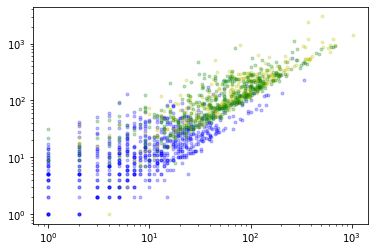

In [57]:
for total_subs, nonsyn_subs in substitutions["Drosophila simulans"].values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.b', alpha=0.25)
    
for total_subs, nonsyn_subs in substitutions["Drosophila pseudoobscura"].values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.y', alpha=0.25)
   
for total_subs, nonsyn_subs in substitutions["Drosophila serrata"].values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.g', alpha=0.25)

In [31]:
sorted(substitutions["Drosophila pseudoobscura"])

['10178782',
 '10178796',
 '10178797',
 '10178814',
 '10178822',
 '10178824',
 '10178825',
 '10178837',
 '10178840',
 '10178847',
 '10178852',
 '10178853',
 '10178859',
 '10178862',
 '10178864',
 '10178870',
 '10178875',
 '10178888',
 '10178891',
 '10178894',
 '10178897',
 '10178905',
 '10178909',
 '10178910',
 '10178911',
 '10178912',
 '10178923',
 '10178928',
 '10178929',
 '10178930',
 '10178932',
 '10178935',
 '10178940',
 '10178941',
 '10178950',
 '10178951',
 '10178954',
 '10178957',
 '10178961',
 '10178965',
 '10178968',
 '117294',
 '117300',
 '117331',
 '117332',
 '117338',
 '117339',
 '117342',
 '117343',
 '117344',
 '117347',
 '117348',
 '117353',
 '117361',
 '117364',
 '117365',
 '117366',
 '117368',
 '117406',
 '117407',
 '117414',
 '117419',
 '117459',
 '117460',
 '117475',
 '117476',
 '117477',
 '117480',
 '117481',
 '117484',
 '117498',
 '117501',
 '117503',
 '118436',
 '12797866',
 '12797890',
 '12797893',
 '12797894',
 '12797895',
 '12797949',
 '12797977',
 '12798024',


## TO-DO:
- Repeat for different genes
- Plots of DN vs DS, where each point is a species comparison
- Scatterplot of DN vs DS, where each point is a gene
- The same, but highlighting a set of genes of interest

In [34]:
bases = set(["A", "C", "G", "T"])
for comb in product(bases, repeat=3):
    s = Seq("".join(comb))
    print(s, "->", s.translate())

CCC -> P
CCA -> P
CCT -> P
CCG -> P
CAC -> H
CAA -> Q
CAT -> H
CAG -> Q
CTC -> L
CTA -> L
CTT -> L
CTG -> L
CGC -> R
CGA -> R
CGT -> R
CGG -> R
ACC -> T
ACA -> T
ACT -> T
ACG -> T
AAC -> N
AAA -> K
AAT -> N
AAG -> K
ATC -> I
ATA -> I
ATT -> I
ATG -> M
AGC -> S
AGA -> R
AGT -> S
AGG -> R
TCC -> S
TCA -> S
TCT -> S
TCG -> S
TAC -> Y
TAA -> *
TAT -> Y
TAG -> *
TTC -> F
TTA -> L
TTT -> F
TTG -> L
TGC -> C
TGA -> *
TGT -> C
TGG -> W
GCC -> A
GCA -> A
GCT -> A
GCG -> A
GAC -> D
GAA -> E
GAT -> D
GAG -> E
GTC -> V
GTA -> V
GTT -> V
GTG -> V
GGC -> G
GGA -> G
GGT -> G
GGG -> G


In [35]:
codons = (Seq("".join(b)) for b in product(bases, repeat=3))
genetic_code = {
    codon: codon.translate()
    for codon in codons
    if codon.translate() != Seq("*")
}

In [36]:
def count_differences(codon1, codon2):
    return sum(b1 != b2 for b1, b2 in zip(codon1, codon2))

nonsyn_counts = Counter()
syn_counts = Counter()
for codon1, codon2 in combinations(genetic_code, 2):
    if count_differences(codon1, codon2) == 1:
        if genetic_code[codon1] == genetic_code[codon2]:
            syn_counts[codon1] += 1
            syn_counts[codon2] += 1
        else:
            nonsyn_counts[codon1] += 1
            nonsyn_counts[codon2] += 1

In [37]:
for codon in genetic_code:
    print(codon, nonsyn_counts[codon], syn_counts[codon])

CCC 6 3
CCA 6 3
CCT 6 3
CCG 6 3
CAC 8 1
CAA 7 1
CAT 8 1
CAG 7 1
CTC 6 3
CTA 5 4
CTT 6 3
CTG 5 4
CGC 6 3
CGA 4 4
CGT 6 3
CGG 5 4
ACC 6 3
ACA 6 3
ACT 6 3
ACG 6 3
AAC 8 1
AAA 7 1
AAT 8 1
AAG 7 1
ATC 7 2
ATA 7 2
ATT 7 2
ATG 9 0
AGC 8 1
AGA 6 2
AGT 8 1
AGG 7 2
TCC 6 3
TCA 4 3
TCT 6 3
TCG 5 3
TAC 6 1
TAT 6 1
TTC 8 1
TTA 5 2
TTT 8 1
TTG 6 2
TGC 7 1
TGT 7 1
TGG 7 0
GCC 6 3
GCA 6 3
GCT 6 3
GCG 6 3
GAC 8 1
GAA 7 1
GAT 8 1
GAG 7 1
GTC 6 3
GTA 6 3
GTT 6 3
GTG 6 3
GGC 6 3
GGA 5 3
GGT 6 3
GGG 6 3


In [38]:
nonsyn_total = sum(nonsyn_counts.values())
syn_total = sum(syn_counts.values())
print(nonsyn_total / syn_total)

2.925373134328358


In [45]:
def expected_dnds(seq, nonsyn_counts, syn_counts):
    nonsyn = 0
    syn = 0
    for i in range(0, len(seq), 3):
        codon = seq[i:i+3]
        try:
            nonsyn += nonsyn_counts[codon]
            syn += syn_counts[codon]
        except KeyError:
            return None
    return nonsyn / syn

In [40]:
gene_ids = [f.split(".")[0] for f in files]
focal_species = "Drosophila melanogaster"
expectations = {}
for gene_id in gene_ids:
    records = import_fasta(gene_id, datadir)
    longest_records = longest_record_per_species(records)
    if focal_species not in longest_records:
        continue
    seq = longest_records[focal_species].seq
    expectations[gene_id] = expected_dnds(seq, nonsyn_counts, syn_counts)

(array([  7.,  22.,  96., 272., 249., 102.,  32.,  13.,   3.,   1.]),
 array([2.26655443, 2.52462121, 2.78268799, 3.04075477, 3.29882155,
        3.55688833, 3.81495511, 4.07302189, 4.33108866, 4.58915544,
        4.84722222]),
 <BarContainer object of 10 artists>)

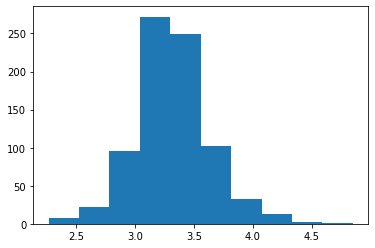

In [41]:
plt.hist(expectations.values())

In [46]:
omega = {}
for gene_id, (total_subs, nonsyn_subs) in substitutions["Drosophila pseudoobscura"].items():
    syn_subs = total_subs - nonsyn_subs
    dnds_obs = nonsyn_subs / syn_subs
    dnds_exp = expectations[gene_id]
    print(dnds_obs, dnds_exp)
    omega[gene_id] = dnds_obs / dnds_exp

0.0 3.3214285714285716
0.7098214285714286 3.5269709543568464
0.4782608695652174 3.409356725146199
0.5813953488372093 3.3485714285714288
0.8151260504201681 3.2140350877192985
0.4838709677419355 3.5531914893617023
0.6470588235294118 3.5492957746478875
0.6333333333333333 3.5463917525773194
0.4583333333333333 3.0
0.7037037037037037 3.1808510638297873
0.5 2.735905044510386
0.8157894736842105 3.65
0.5894736842105263 3.1481481481481484
0.6410256410256411 3.7472527472527473
0.7658227848101266 3.1409921671018277
0.5531914893617021 3.4191176470588234
0.734375 3.8692579505300353
0.4868421052631579 3.2350230414746544
0.4024390243902439 3.013157894736842
0.6086956521739131 2.9621451104100944
0.5342465753424658 3.437837837837838
0.461038961038961 2.933526011560694
0.7192982456140351 3.815151515151515
0.7954545454545454 2.4983498349834985
0.6785714285714286 3.370967741935484
0.6304347826086957 3.0692307692307694
1.0 3.125
0.7226277372262774 3.254071661237785
0.4418604651162791 3.6077586206896552
0.91

(array([11., 29., 49., 65., 83., 83., 27.,  5.,  4.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.03904306, 0.07808612, 0.11712919, 0.15617225,
        0.19521531, 0.23425837, 0.27330144, 0.3123445 , 0.35138756,
        0.39043062, 0.42947368, 0.46851675, 0.50755981, 0.54660287,
        0.58564593, 0.624689  , 0.66373206, 0.70277512, 0.74181818,
        0.78086124, 0.81990431, 0.85894737, 0.89799043, 0.93703349,
        0.97607656]),
 <BarContainer object of 25 artists>)

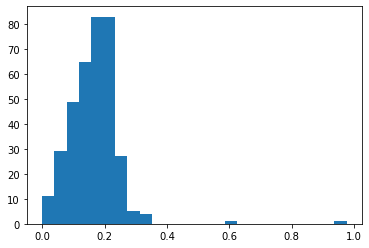

In [55]:
plt.hist(omega.values(), bins=25)

In [56]:
sorted(omega.items(), key=lambda x: x[1], reverse=True)

[('19835902', 0.9760765550239235),
 ('19835366', 0.6212534059945504),
 ('12798530', 0.3296028880866426),
 ('10178930', 0.32876876876876876),
 ('10178923', 0.32),
 ('10178910', 0.3183919779032064),
 ('19836220', 0.30598564290238583),
 ('19834832', 0.2919171676686707),
 ('12798406', 0.2873286248442044),
 ('12798459', 0.27929382564485783),
 ('10178965', 0.27334989592425973),
 ('246562', 0.2646793134598013),
 ('13084062', 0.2643494009473391),
 ('19834939', 0.261455525606469),
 ('12798107', 0.26129032258064516),
 ('246399', 0.2593581238822669),
 ('246561', 0.2573287354687333),
 ('12798108', 0.2572533849129594),
 ('12798213', 0.25603709502285293),
 ('246406', 0.25553462081959494),
 ('12798367', 0.25455141873052317),
 ('12798476', 0.25387511613124053),
 ('10178822', 0.25361454625518326),
 ('12798544', 0.24791297748545407),
 ('246431', 0.24665101505316947),
 ('12798276', 0.2442127794514032),
 ('10178864', 0.24381556656881004),
 ('12798326', 0.24270099237739107),
 ('12798317', 0.242581090407177

In [58]:
sorted(omega.items(), key=lambda x: x[1], reverse=False)

[('10178782', 0.0),
 ('14462486', 0.0),
 ('19835488', 0.014072693383038211),
 ('12798539', 0.022638315878557073),
 ('249072', 0.02690029770486655),
 ('252479', 0.02740608118796081),
 ('117294', 0.029191616766467067),
 ('246620', 0.03166649872190609),
 ('19835431', 0.03202328966521106),
 ('19836008', 0.03394039735099338),
 ('251645', 0.036416799574694306),
 ('246638', 0.043362752161383286),
 ('246602', 0.043795620437956206),
 ('26067053', 0.0446387021663131),
 ('14462836', 0.045777484801875046),
 ('192509', 0.04589463928104467),
 ('117414', 0.04701782074044848),
 ('250736', 0.04751424235441811),
 ('26067054', 0.04926819760368748),
 ('26067039', 0.05090497737556561),
 ('117406', 0.05674964510102654),
 ('118436', 0.05707759181500976),
 ('117332', 0.05843782773243354),
 ('140439', 0.05954164944191814),
 ('249663', 0.06047805103030694),
 ('13084069', 0.06311858504398826),
 ('246452', 0.06378775863311946),
 ('248102', 0.06446715328467154),
 ('246624', 0.06469536096205807),
 ('117480', 0.0647